In [100]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path

In [385]:
from scipy.signal import savgol_filter as smooth
# this function returns the local maxima and the minima
# Input:
# ltp: a panda dataframe with column 'Date_Time' and 'Close'
# n: is the width of window to examine max and min, should be odd and greater than 3
# Return:
# max: the local maxima among the n of its neigbours
# min: the local minima among the n of its neigbours
# min and max are list of tuples in shape [(date,price),(date,price),(),(),...]
def max_min(ltp,n,apply_smooth=True,poly_order=3):
    assert n%2==1, "n should be an odd number greater than 3"
    if apply_smooth:
        ltp_sm = smooth(ltp['Close'],n,poly_order)
    else:
        ltp_sm = ltp['Close']
    max_points = []
    min_points = []
    ltp_dif = np.zeros(ltp_sm.shape[0]-1)
    ltp_dif = ltp_sm[1:]-ltp_sm[:-1]
    center = int((n-1)/2)
    for i in range(ltp_dif.shape[0]-n+2):
        window = ltp_dif[i:i+n-1]
        front = window[:center]
        back = window[center:]
        s_first = np.sum(front<0)
        s_back = np.sum(back>0)
        r_first = np.sum(front>0)
        r_back = np.sum(back<0)
        if(r_first == center and r_back == center):
#             max_point = ltp['Close'].iloc[i+center]
#             max_value_left = ltp['Close'].iloc[i:i+center]-max_point
#             max_value_right = ltp['Close'].iloc[i+center+1:i+2*center+1]-max_point
#             if np.min(max_value_left)<max_point*0.01 and np.min(max_value_right)<rpar:
            max_points.append((ltp['Date_Time'].iloc[i+center],ltp['Close'].iloc[i+center]))
        if(s_first== center and s_back== center):
#             min_value_left = ltp['Close'].iloc[i:i+center]-ltp['Close'].iloc[i+center]
#             min_value_right = ltp['Close'].iloc[i+center+1:i+2*center+1]-ltp['Close'].iloc[i+center]
#             if np.max(min_value_left)>spar and np.max(min_value_right)>spar:
            min_points.append((ltp['Date_Time'].iloc[i+center],ltp['Close'].iloc[i+center]))
    return max_points,min_points

In [499]:
from datetime import timedelta
# this function find the cluster of a series of data according to price and threshold given
# Input:
# pairs: [(data,price)(date,price),...]
# threshold: price within this range will be clustered together
# Return:
# groups of cluster in shape [[(date,price),(date,price),()...],[],...]
# each cluster is sorted in date
# return is in list of list of tuple, each list a cluster
def cluster(pairs, min_points_num,threshold = 0.8,oneyear=0):
    # first sort the given pairs according to price
    pairs = sorted(pairs, key=lambda x: x[1])
    groups = []
    current = []
    # the smallest value in the current group
    vl = 0
    for pair in pairs:
        if not current:
            current.append(pair)
            vl = pair[1]
        elif pair[1]-vl<threshold:
            current.append(pair)
        else:
            if len(current)> min_points_num - 1:
                if oneyear:
                    year = timedelta(days=int(365*oneyear))
                    # split this current group with time
                    current = sorted(current,key=lambda x:x[0])
                    last_time = current[0][0]
                    year_group = []
                    for cur in current:
                        if not year_group:
                            year_group.append(cur)
                            last_time=cur[0]
                        elif cur[0]-last_time<year:
                            year_group.append(cur)
                            last_time = cur[0]
                        else:
                            if len(year_group)>min_points_num-1:
                                groups.append(year_group)
                            last_time = cur[0]
                            year_group=[cur]
                        if(len(year_group)>min_points_num-1):
                            groups.append(sorted(year_group))
                else:
                    groups.append(sorted(current))
                # split ended
            vl = pair[1]
            current = [pair]
    if len(current)>min_points_num-1:
       groups.append(sorted(current))
    return groups

transfer back to numpy array for easiness to index
they are tuple in prior steps because np array only support
one dtype. String and float can not co-exist. For sorting and
clustering purposes, they have to be converted to tuple

In [500]:
# The function produce support, resistance lines out of original data and the clustted group
# In a group, if the line represented by the group not intersected by data in the group,
# or more than or equal to two points on a line is not disturbed by the intersection, then the line is preserved
# Input:
# group_list: in the form [[(),(),()],[(),()],...]
# data:  the original pandas dataframe. It shall be converted into matrix inside the function
# support: is a qualitative variable, True for support and false for demand
# Return:
# group of line in the shape of [pd.dataframe['Date_Ti='Support/Resistance'], pd.dataframe[],.='\==\
# the second row of each dataframe in group is the same

def into_arr(group_list,data,min_points_num,support=True,hard_break_par=0.03):
    groups=[]
    reaction_points =[]
    for group in group_list:
        # extract date, price
        group = sorted(group)
        date = np.asarray(group)[:,0]
        price = np.asarray(group)[:,1]
        price = price.astype(np.float)
        # form line, calculate when line start and stop
        average_price = np.average(price)
        mask_after_first = data[:,0] > date[0]
        if support:
            # hard break is the absolute breakthrough
            hard_break = (np.min(price)-data[:,1])/np.min(price)
            # whereas sfotbreak alllows scaled break through
            break_through = hard_break >hard_break_par
        else:
            hard_break = (data[:,1]-np.max(price))/np.max(price)
            break_through = hard_break >hard_break_par
        break_through = np.bitwise_and(break_through,mask_after_first)
                    
        # fix the intersection and eliminate the fake lines
        slicing_date = date
        break_times = np.array([])
        if np.sum(np.argwhere(break_through))>0:
            break_times = data[:,0][np.argwhere(break_through)]
        for break_time in break_times:
            # num_before_break is the num of reaction
            num_before_break = np.sum(slicing_date<break_time)
            # min_points_num or more times before break through, form a line
            if num_before_break > min_points_num-1:
                # the last point before the break point
                where_date_before_break = np.argwhere(slicing_date<break_time)
                last_point_before_break = where_date_before_break[-1][0]
                
                # measure the length of time between break time and the support range
                # if the difference is too huge, then this line does not look well, discard
                break_len = break_time[0]-slicing_date[last_point_before_break]
                sr_len = slicing_date[last_point_before_break]-slicing_date[0]
                # if the length of support/resistance is too short compared with 
                # break time, then do not need this line
                if break_len>5*sr_len:
                    slicing_date=slicing_date[last_point_before_break+1:]
                    continue

                date_range = pd.date_range(slicing_date[0],break_time[0])
                # incorporating number of reaction to column name
                column_name = 'support_'+str(num_before_break)+'_'
                if(not support):
                    column_name = 'resistance_'+str(num_before_break)+'_'
                df = pd.DataFrame({column_name:[average_price for i in range(date_range.shape[0])]},index=date_range)
                groups.append(df)
                # now append the reaction points
                reaction_points.extend(slicing_date[where_date_before_break].flatten())
                
                if slicing_date.shape[0] > last_point_before_break+1+min_points_num:
                    slicing_date = slicing_date[last_point_before_break+1:]
                else:
                    slicing_date = np.array([])
            # less than min_points_num point before break through, discard
            elif slicing_date.shape[0] > min_points_num-1:
                slicing_date = slicing_date[num_before_break:]
            # no points before break through
            else:
                break               
        # if break_time runs out but slicing_date stills exist,
        # breaks in the middle, and exist until the last points
        # or no break points at all
        if slicing_date.shape[0]>min_points_num:
            last_date = data[:,0][-1]
            date_range = pd.date_range(slicing_date[0],last_date)
            # incorporating number of reaction to column name
            column_name = 'support_'+str(slicing_date.shape[0])+'_'
            if(not support):
                column_name = 'resistance_'+str(slicing_date.shape[0])+'_'
            df = pd.DataFrame({column_name:[average_price for i in range(date_range.shape[0])]},index=date_range)
            groups.append(df)
            reaction_points.extend(slicing_date.flatten())
    return [groups,reaction_points]
# the algorithm uses a break-point by break-point approach to check whether a group of min/max points is valided.
# for each breakpoint, if it intersectes as of time with the current group, then if there are two or more points
# before the intersected breakthough, the segmented lines should be kept, otherwise discarded. Then we check the
# next breaktime. Notice that the obvious dawback of this approach is its high computational intensity, namely all
# points within the break_through series, which could be very long has to be checked.

In [493]:
# merge the support and resistance with the original dataframe, and possibly plot it out
# Input:
# data: original pandas dataframe
# support: the support group in the shape [pd.dataframe['Date_Time','Support/Resistance'], pd.dataframe[],...]
# resistance: the resistant group in the shape [pd.dataframe['Date_Time','Support/Resistance'], pd.dataframe[],...]
# render: whether or not to plot out the data
# Return:
# the merged data containing Date_time, close, and the subsequent support and resistance columns
# NaN will be filled in when the support line or resistance line does not fully covers the whole time frame
def plot_sr(data,support_line_and_reaction,resist_line_and_reaction,render):
    support_lines = support_line_and_reaction[0]
    resist_lines = resist_line_and_reaction[0]
    color=['b']
    counter = 1
    for support in support_lines:
        support.rename(columns={'support':'support'+str(counter)}, inplace=True)
        val = support.iloc[1,-1]
        data = data.merge(support,how='left',left_on='Date_Time',right_index=True)
        first = data.index.get_loc(data.iloc[:,-1].first_valid_index())
        last = data.index.get_loc(data.iloc[:,-1].last_valid_index())
        data.iloc[first:last,-1]=val
        color.append('g')
        counter = counter+1
    for resist in resist_lines:
        resist.rename(columns={'resistance':'resistance'+str(counter)}, inplace=True)
        val = resist.iloc[1,-1]
        data = data.merge(resist,how='left',left_on='Date_Time',right_index=True)
        first = data.index.get_loc(data.iloc[:,-1].first_valid_index())
        last = data.index.get_loc(data.iloc[:,-1].last_valid_index())
        data.iloc[first:last,-1]=val
        color.append('r')
    if render:
        df = data.set_index('Date_Time')
        s_dates = support_line_and_reaction[1]
        r_dates = resist_line_and_reaction[1]
        srdf = pd.DataFrame(data=None,index=df.index)
        srdf.loc[s_dates,'Min']=df.loc[s_dates,'Close']
        srdf.loc[r_dates,'Max']=df.loc[r_dates,'Close']
        plt.plot(df.index,df['Close'],c='b',linewidth=1)
        for column in df.columns[1:counter]:
            plt.plot(df.index,df[column],c='g',linewidth=2)
        for column in df.columns[counter:]:
            plt.plot(df.index,df[column],c='r',linewidth=2)
        plt.plot(df.index,srdf.Min,marker='o',markersize=3,c='g')
        plt.plot(df.index,srdf.Max,marker='o',markersize=3,c='r')
        plt.show()
    return data

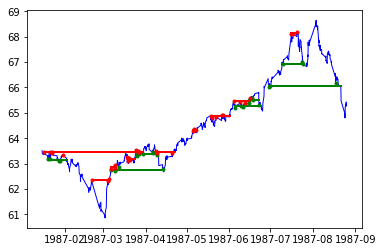

In [515]:
# # date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
# # # ltp,n,smooth=True,poly_order=3
# # tpdata = pd.read_table('data/source_txt/@CL_60min.txt',delimiter=',',header=0,parse_dates=[['Date','Time']],usecols=['Date','Time','Close'])
# tpdata1 = tpdata[0:1000]
# maxima,minima = max_min(tpdata1,5)
# # print(len(maxima))
# # print(len(minima))
# max_group = cluster(maxima,3,threshold=0.2,oneyear=0.5)
# min_group = cluster(minima,3,threshold=0.2,oneyear=0.5)
# # print(max_group)
# # print(len(min_group))
# # print(len(max_group))
# # generate the support and resistance line group
# support = into_arr(min_group,tpdata1.as_matrix(),3,True,hard_break_par=0)
# resistance = into_arr(max_group,tpdata1.as_matrix(),3,False,hard_break_par=0)
# close_sr = plot_sr(tpdata1,support,resistance,True).set_index('Date_Time')

In [209]:
def main():
    import argparse
    parser = argparse.ArgumentParser(description = 'input arguments')
    parser.add_argument('data_file',type=str)
    parser.add_argument('--check_all',action='store_true',
                        help='supply support resistance to all data from the source')
    parser.add_argument('--start',type=int,default=0,
                        help='start point of checking the data, default=0, will be overriden if --check_all')
    parser.add_argument('--end',type=int,default=500,
                        help='end point of checking the data, default=500,will be overriden if --check_all')
    parser.add_argument('--scanning_window',type=int,default=5,
                        help='the width of the scanning window to find local max and min points, default 5')
    parser.add_argument('--cluster_threshold_s',type=float,default=1,
                        help='the threshold within which data of each price is grouped together, default 1')
    parser.add_argument('--cluster_threshold_r',type=float,default=0.8,
                        help='the threshold within which data of each price is grouped together, default 0.8')
    parser.add_argument('--min_points_num_for_line',type=int,default=2,
                        help='the min interation to form a line, the more the number, the less the lines, default 2')
    parser.add_argument('--min_points_num_for_cluster',type=int,default=3,
                        help='the min interation to form a line, the more the number, the less the lines, default 3')
    parser.add_argument('--hard_break_par_s',type=int,default=0.003,
                        help='control break throughs, default 0.03')
    parser.add_argument('--hard_break_par_r',type=int,default=0.03,
                        help='control break throughs, default 0.003')
    parser.add_argument('--oneyear',type=float,default=0.5)
    parser.add_argument('--save_result',action='store_true',
                        help='save output to filename_sr.csv')
    parser.add_argument('--render',action='store_true',
                        help='plot support and resistance')
    args = parser.parse_args()
    
    if os.path.exists(args.data_file):
        # read in the Date, Time, Close column of data
        date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        tpdata = pd.read_table(args.data_file,delimiter=',',header=0,parse_dates=[['Date','Time']],usecols=['Date','Time','Close'])
        
        if not args.check_all:
            assert args.start > -1,'the start index has to be positive'
            assert args.start < tpdata.shape[0], 'the start index has to be smaller than length of data %d'%len(tpdata.shape)
            assert args.end > 0,'the end index has to be positive'
            assert args.end < tpdata.shape[0], 'the end index has to be smaller than length of data %d'%len(tpdata.shape)
            tpdata = tpdata[args.start:args.end]
            
        # find the local max and min
        maxima,minima = max_min(tpdata,args.scanning_window)
        # cluster the max and min to form groups
        max_group = cluster(maxima,args.min_points_num_for_cluster,args.cluster_threshold_s,oneyear=3)
        min_group = cluster(minima,args.min_points_num_for_cluster,args.cluster_threshold_r,oneyear=3)
        # generate the support and resistance line group
        support = into_arr(min_group,tpdata.as_matrix(),args.min_points_num_for_line,True,args.hard_break_par_s)
        resistance = into_arr(max_group,tpdata.as_matrix(),args.min_points_num_for_line,False,args.hard_break_par_r)
        # plot the results
        close_sr = plot_sr(tpdata,support,resistance,args.render)
        # merge the full data with support and resistance
        # the new support and resistance lines shall become extra columns
        full_data =  pd.read_table(args.data_file,delimiter=',',header=0,parse_dates=[['Date','Time']])
        if not args.check_all:
            full_data = full_data[args.start:args.end]
        full_data = full_data.merge(close_sr,how='left',on='Date_Time').set_index('Date_Time')
        # save the result if needed
        if args.save_result:
            # save the cleansed data into new csv data
            output_dir = args.data_file.split('/')[0]+'/output_csv'
            output_file_name = os.path.splitext(args.data_file.split('/')[-1])[0]+'_sr.csv'
            output_file_path = output_dir + '/'+ output_file_name
            if(not os.path.exists(output_dir)):
                os.mkdir(output_dir)
            full_data.to_csv(output_file_path)
            print('the data with support and resistance added is saved at %s' %output_file_path)
        print('support and resistance founded!')
    else:
        print("data_file not found!")

In [106]:
if __name__ == '__main__':
    main()

usage: ipykernel_launcher.py [-h] [--check_all] [--start START] [--end END]
                             [--scanning_window SCANNING_WINDOW]
                             [--cluster_threshold CLUSTER_THRESHOLD]
                             [--min_points_num_for_line MIN_POINTS_NUM_FOR_LINE]
                             [--save_result] [--render]
                             data_file
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/home/elessar/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
